In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, Lars, LassoLars, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Huber, OrthogonalMatchingPursuit
from sklearn.dummy import DummyClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
test.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
1,58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
2,58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
3,58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
4,58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39098 entries, 0 to 39097
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39098 non-null  int64  
 1   person_age                  39098 non-null  int64  
 2   person_income               39098 non-null  int64  
 3   person_home_ownership       39098 non-null  object 
 4   person_emp_length           39098 non-null  float64
 5   loan_intent                 39098 non-null  object 
 6   loan_grade                  39098 non-null  object 
 7   loan_amnt                   39098 non-null  int64  
 8   loan_int_rate               39098 non-null  float64
 9   loan_percent_income         39098 non-null  float64
 10  cb_person_default_on_file   39098 non-null  object 
 11  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.6+ MB


Bu grafikte, özellikle genç yaş gruplarının krediye daha fazla başvurduğunu ancak kredi alma oranlarının düşük olduğunu gözlemliyoruz. Yaş ilerledikçe hem başvuru sayısı azalıyor hem de kredi alma ihtimali oldukça düşüyor gibi görünüyor.

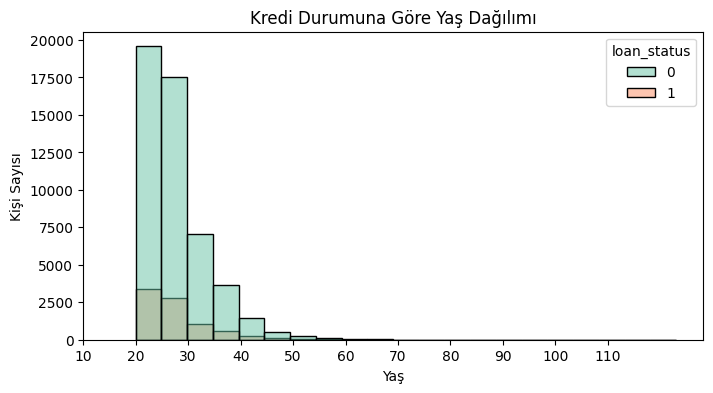

In [34]:
plt.figure(figsize=(8, 4))
sns.histplot(data=train, x="person_age", hue="loan_status", binwidth=5, palette='Set2')
plt.xticks(ticks=np.arange(10, 120, 10))

plt.xlabel("Yaş")
plt.ylabel("Kişi Sayısı")
plt.title("Kredi Durumuna Göre Yaş Dağılımı")

plt.show()

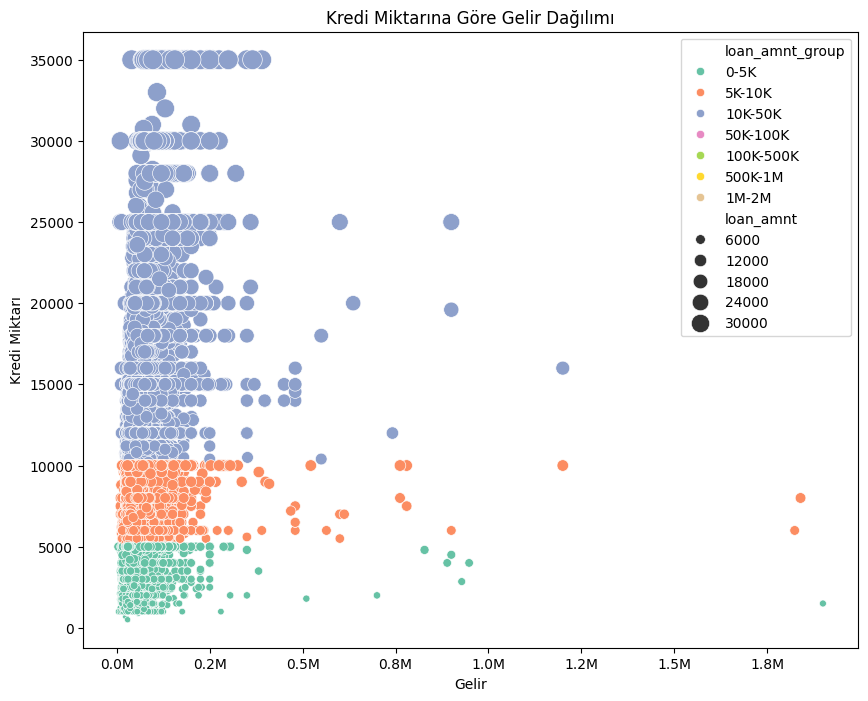

In [65]:
plt.figure(figsize=(10, 8))
train['loan_amnt_group'] = pd.cut(train['loan_amnt'], 
                                  bins=[0, 5000, 10000, 50000, 100000, 500000, 1000000, 2000000], 
                                  labels=['0-5K', '5K-10K', '10K-50K', '50K-100K', 
                                          '100K-500K', '500K-1M', '1M-2M'])

sns.scatterplot(data=train, x="person_income", y="loan_amnt", 
                size="loan_amnt", sizes=(20, 200), hue="loan_amnt_group", palette="Set2")
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x / 1e6:.1f}M'))

plt.xlabel("Gelir")
plt.ylabel("Kredi Miktarı")
plt.title("Kredi Miktarına Göre Gelir Dağılımı")

plt.show()

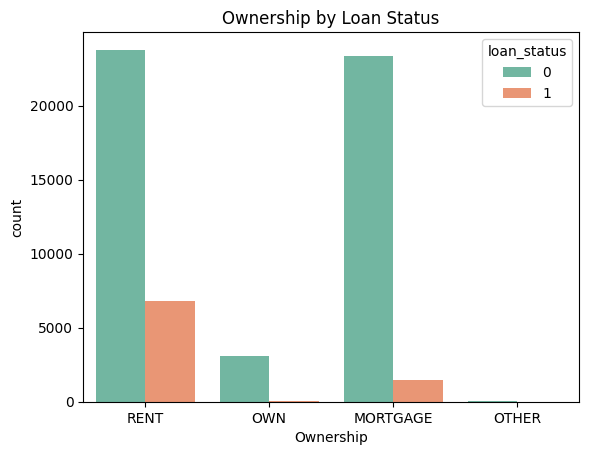

In [77]:
sns.countplot(data=train, x="person_home_ownership", hue="loan_status", palette='Set2')
plt.xlabel("Ownership")
plt.title("Ownership by Loan Status")

plt.show()

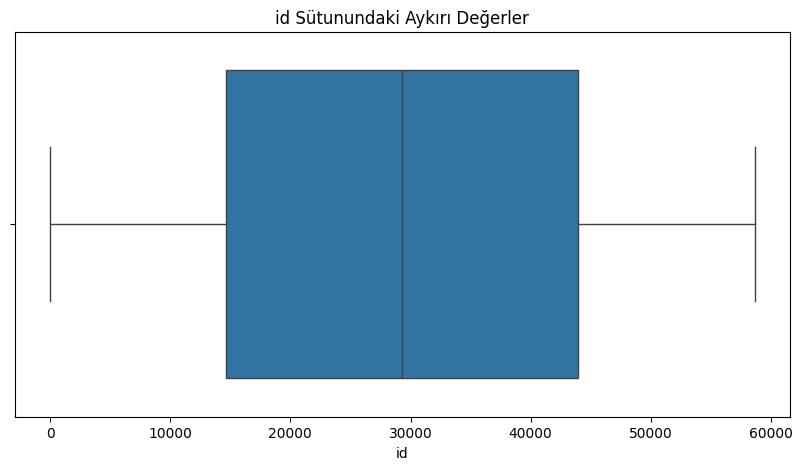

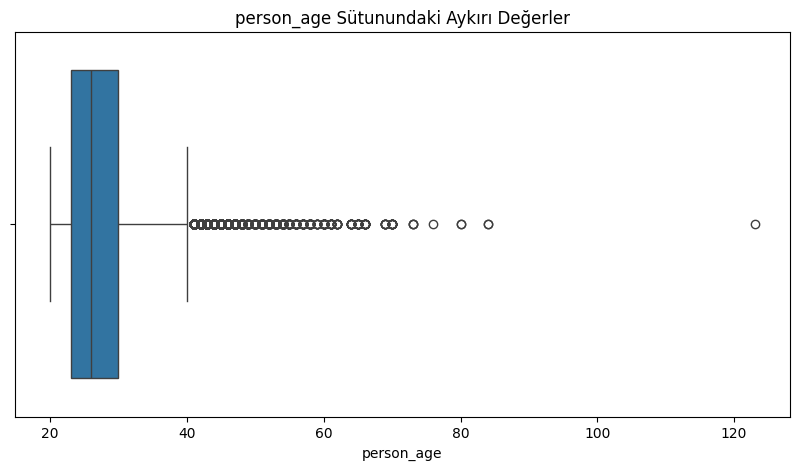

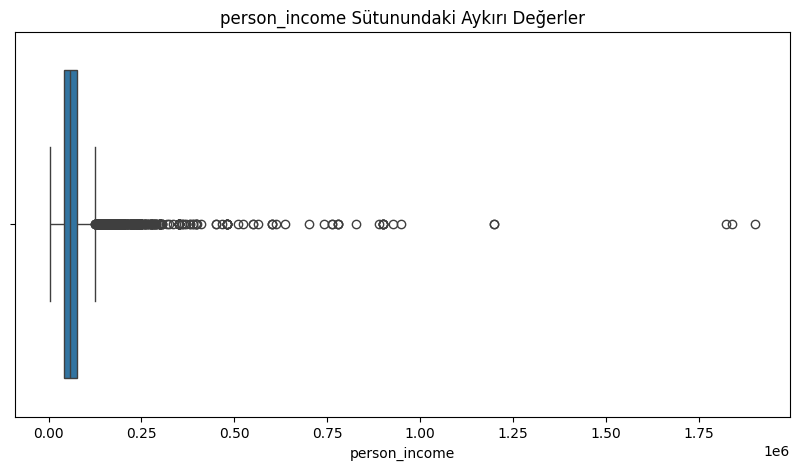

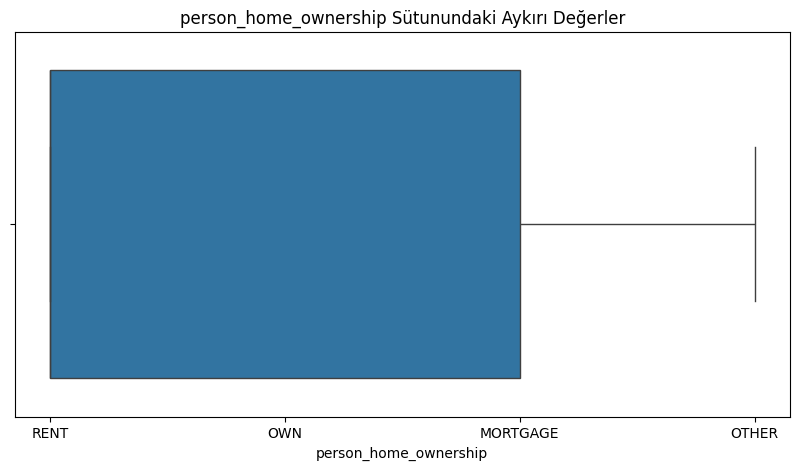

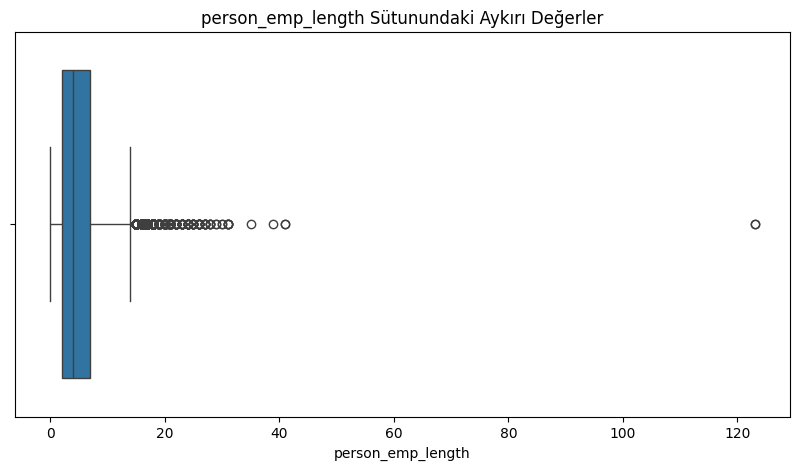

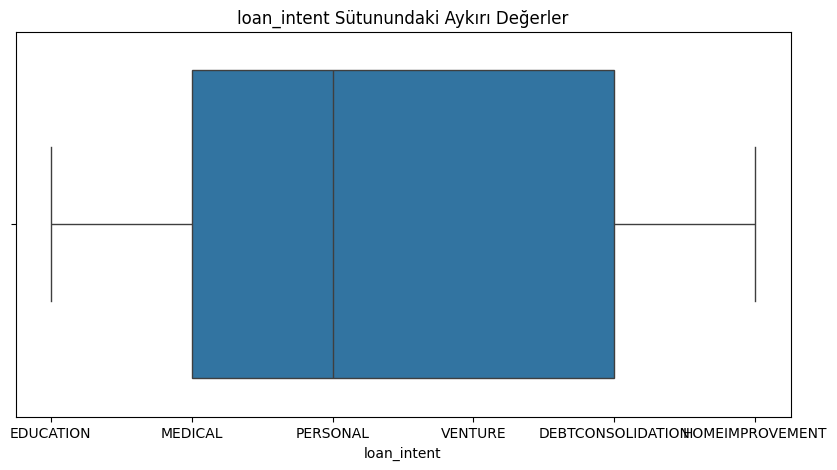

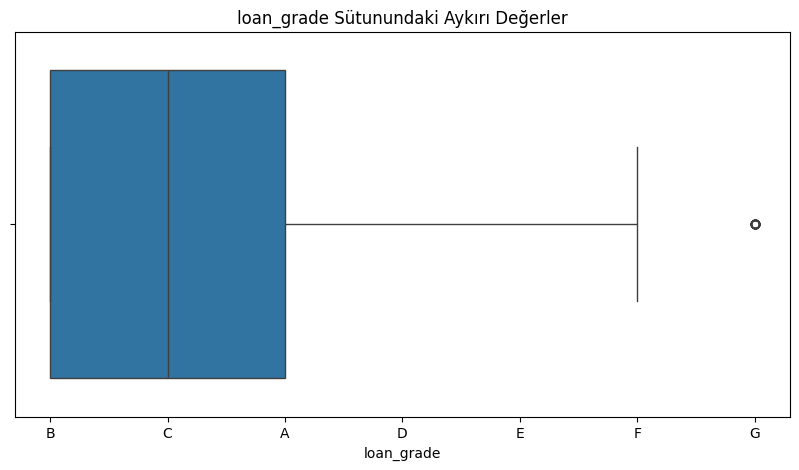

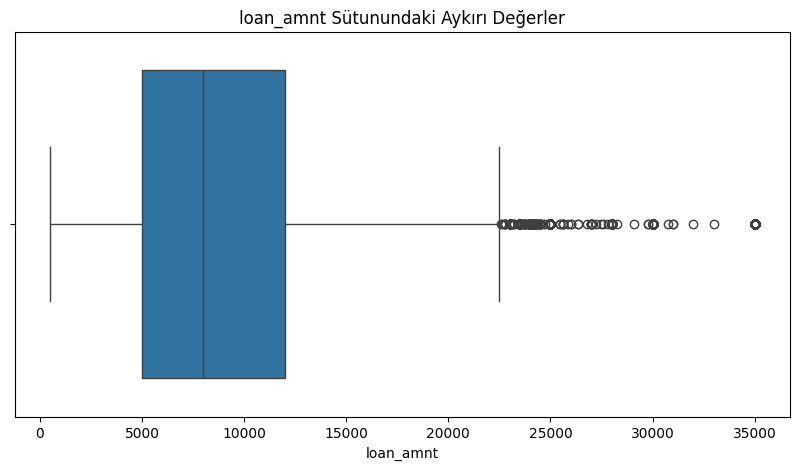

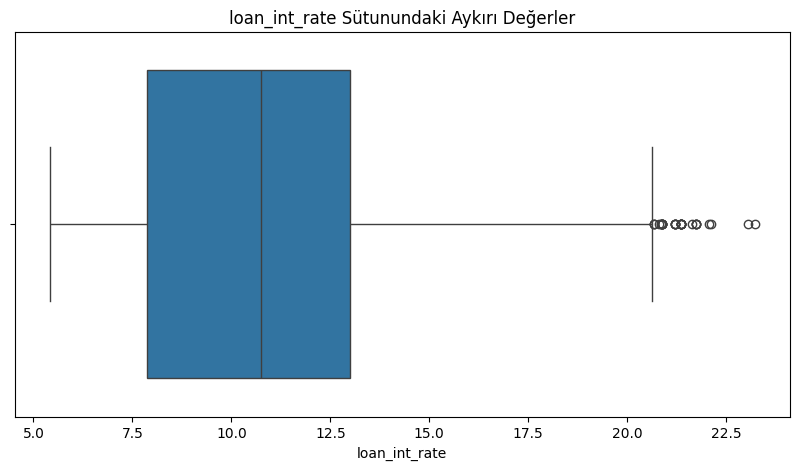

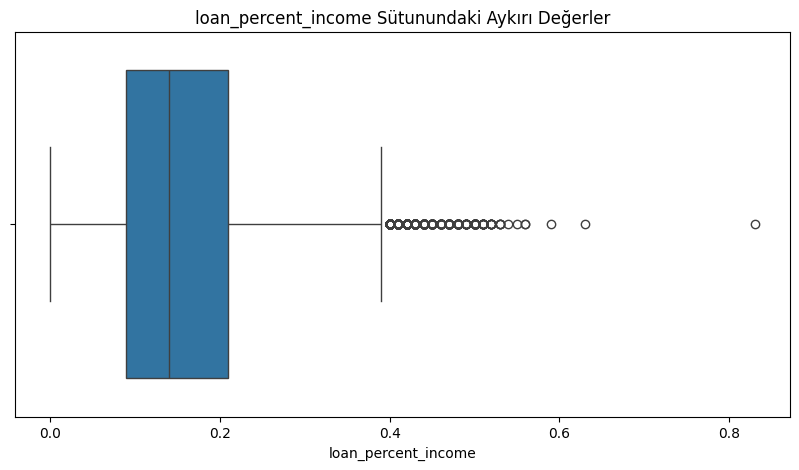

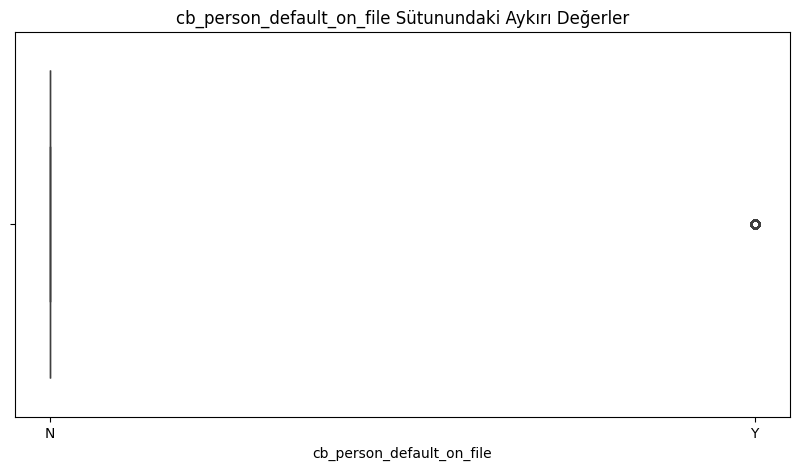

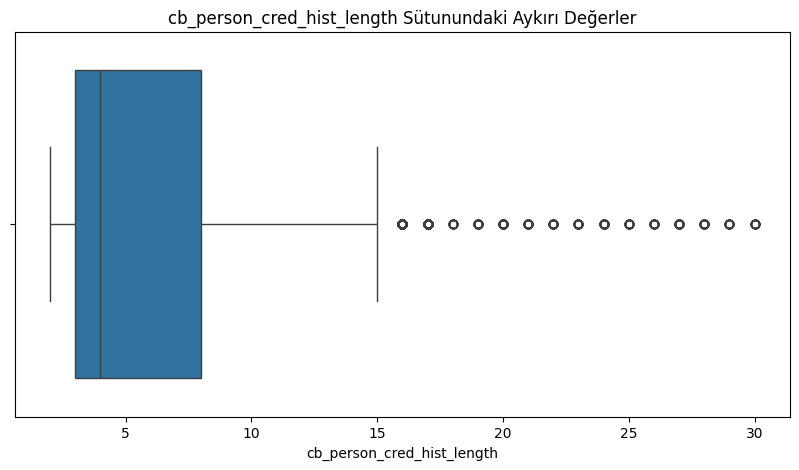

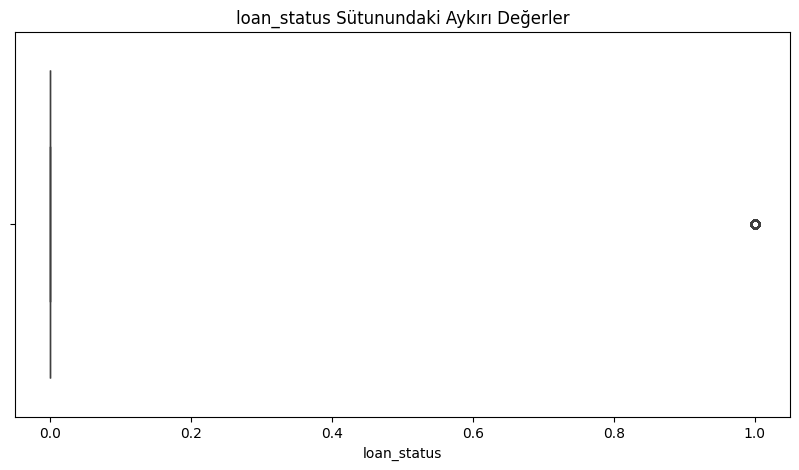

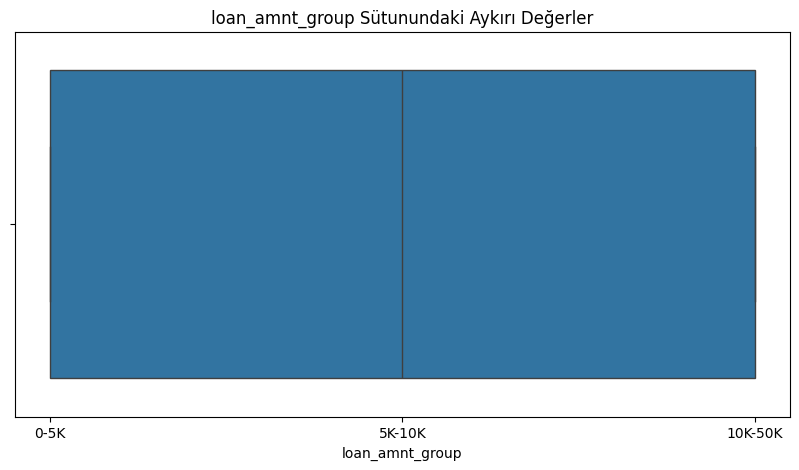

In [132]:

for col in train.columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=train[col])
    plt.title(f'{col} Sütunundaki Aykırı Değerler')
    plt.show()

In [138]:
Q1 = train['person_income'].quantile(0.25)
Q3 = train['person_income'].quantile(0.75)
IQR = Q3 - Q1

# Alt ve üst sınırlar
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [142]:
train.loc[train['person_age'] > 80, 'person_age'] = upper_bound
train.loc[train['person_emp_length'] > 60, 'person_emp_length'] = upper_bound

In [150]:
le = LabelEncoder()

object_columns = train.select_dtypes(include='object')

for col in object_columns:
    train[col] = le.fit_transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

In [162]:
X = train.drop(['id', 'loan_status', 'loan_amnt_group'], axis=1)
y = train['loan_status']

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [171]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [181]:
pd.set_option('display.max_colwidth', None)

models = {
    'Logistic Regression': (LogisticRegression(), {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'saga']
    }),
    'Gradient Boosting Classifier': (GradientBoostingClassifier(), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7]
    }),
    'Random Forest Classifier': (RandomForestClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }),
    'Extra Trees Classifier': (ExtraTreesClassifier(), {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20]
    }),
    'AdaBoost Classifier': (AdaBoostClassifier(), {
        'n_estimators': [50, 100],
        'learning_rate': [1.0, 1.5]
    }),
    'Decision Tree Classifier': (DecisionTreeClassifier(), {
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5]
    }),
    'K Neighbors Classifier': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }),
    'Dummy Classifier': (DummyClassifier(strategy='most_frequent'), {}),
    'Extreme Gradient Boosting': (xgb.XGBClassifier(), {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1]
    }),
    'CatBoost Classifier': (CatBoostClassifier(learning_rate=0.1, depth=6, iterations=500, verbose=0), {}),
    'Hist Gradient Boosting Classifier': (HistGradientBoostingClassifier(), {
        'max_iter': [100, 200],
        'max_depth': [3, 5]
    }),
}

results = {}

# Her model için GridSearchCV uygulama
for name, (model, params) in models.items():
    if params:  # Eğer hiperparametreler varsa
        grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train_scaled, y_train)
        
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        
        scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
        
        results[name] = {
            'Best Params': best_params,
            'Best Score': best_score,
            'Mean ROC': scores.mean(),
            'Std': scores.std()
        }
    else:
        # Hiperparametre ayarlaması gerektirmeyen modeller için basit bir değerlendirme
        scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
        results[name] = {
            'Mean Roc': scores.mean(),
            'Std': scores.std()
        }

results_df = pd.DataFrame.from_dict(results, orient='index')
print(results_df.sort_values(by='Best Score', ascending=False))

                                                                                      Best Params  \
Gradient Boosting Classifier          {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}   
Hist Gradient Boosting Classifier                               {'max_depth': 5, 'max_iter': 200}   
Extreme Gradient Boosting             {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}   
Random Forest Classifier           {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}   
AdaBoost Classifier                                   {'learning_rate': 1.5, 'n_estimators': 100}   
Extra Trees Classifier                                     {'max_depth': 20, 'n_estimators': 100}   
Decision Tree Classifier                                 {'max_depth': 5, 'min_samples_split': 5}   
K Neighbors Classifier                                  {'n_neighbors': 7, 'weights': 'distance'}   
Logistic Regression                                            {'C': 0.01, 'solver': 'libli

In [185]:
X_train = train.drop(['id', 'loan_status', 'loan_amnt_group'], axis=1)
y_train = train['loan_status']
X_test = test.drop('id', axis=1)

In [187]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [189]:
model = GradientBoostingClassifier()
model.fit(X_train_scaled, y_train)

GradientBoostingClassifier()

In [191]:
y_pred = model.predict(X_test_scaled)

In [193]:
submission = pd.read_csv('sample_submission.csv')
submission['loan_status'] = y_pred

In [196]:
submission.to_csv('sample_submission.csv', index=False)